# Neural network from scratch.

Based on YSDA Deep Learning course materials.

https://github.com/yandexdataschool/Practical_DL/blob/spring2019/homework01/homework_modules.ipynb

We will implement most common layers using `numpy` for matrix operations.

The file `modules.py` contains the abstract classes for **module**, **criterion** and **sequential** model class.

**Module** is an abstract class which defines the fundamental methods required for training a neural network.

**Criterion** class implements a container which can be used to score the models answers.

**Sequential** class implements a container which processes `input` data sequentially.


#### Tips and tricks
Original `numpy` operation are preferable to the overloaded ones (`+`, `*`, `-`, etc. vs `np.add`, `np.multiply`, `np.substract`). They are less prone to excess memory usage and seem unified with tensor frameworks.

*Example:*

```
a = np.zeros_like(arr1)

a = arr1 + arr2 #  bad, we reallocate memory for the result of + operation

a = np.zeros_like(arr1)

np.add(arr1, arr2, out=a) #  good, we use same allocated memory, no need to call gc
```

But I won't follow that advice ;)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display


In [2]:
!wget -O modules.py https://github.com/girafe-ai/ml-course/blob/b57d7c8df19b6166dbc173ee027f9fdd55cc8686/week0_07_intro_to_DL/modules.py?raw=true

zsh:1: no matches found: https://github.com/girafe-ai/ml-course/blob/b57d7c8df19b6166dbc173ee027f9fdd55cc8686/week0_07_intro_to_DL/modules.py?raw=true


In [3]:
from modules import Module, Sequential, Criterion

## Impelementing main layers


Let's try to implement some layers in numpy.
Today we are going to discuss only the most common ones.

https://en.wikipedia.org/wiki/Matrix_calculus



[Post about einsum](https://habr.com/ru/post/544498/)

### 1. Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_in`**
- output  **`batch_size x n_out`**

[Backpropagation for a Linear Layer handout](http://cs231n.stanford.edu/handouts/linear-backprop.pdf)

In [4]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_in, n_out))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        multiply = np.matmul(input, self.W)
        a = np.zeros_like(multiply)
        np.add(self.b, multiply, out=a)
        self.output = a
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.dot(gradOutput, self.W.T)
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradW = np.dot(input.T, gradOutput)
        self.gradb = np.sum(gradOutput, axis=0)

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

In [7]:
import torch
from torch import nn

K = 10  # Input features
N = 8  # Output features
B = 10  # Batch size

linear_torch = nn.Linear(in_features=K, out_features=N, bias=True)
x_torch = torch.rand((B, K), requires_grad=True)
y_grad_torch = torch.rand((B, N))
y_torch = linear_torch(x_torch)
y_torch.backward(y_grad_torch)

print("Torch реализация:")
print("x", x_torch)
print("Градиент по входу:", x_torch.grad)
print("Градиент по весам:", linear_torch.weight.grad)
print("Градиент по биасу:", linear_torch.bias.grad)

linear_custom = Linear(K, N)
x_custom = x_torch.cpu().detach().numpy()
y_grad_custom = y_grad_torch.cpu().detach().numpy()
# Прямой
y_custom = linear_custom.updateOutput(x_custom)
# Обратный
grad_input_custom = linear_custom.updateGradInput(x_custom, y_grad_custom)
linear_custom.accGradParameters(x_custom, y_grad_custom)

print("\nКасотмная реализация:")
print("x", x_custom)
print("Градиент по входу:", grad_input_custom)
print("Градиент по весам:", linear_custom.gradW)
print("Градиент по биасу:", linear_custom.gradb)

Torch реализация:
x tensor([[0.8391, 0.4045, 0.8891, 0.9028, 0.5249, 0.7957, 0.2646, 0.1695, 0.6978,
         0.2646],
        [0.3014, 0.5556, 0.9591, 0.4573, 0.6053, 0.4240, 0.2461, 0.7539, 0.1489,
         0.6977],
        [0.4476, 0.6522, 0.1398, 0.1645, 0.6364, 0.4846, 0.9859, 0.4614, 0.7319,
         0.0257],
        [0.4800, 0.8606, 0.1086, 0.5764, 0.9498, 0.4359, 0.2249, 0.5004, 0.2750,
         0.9518],
        [0.0296, 0.3078, 0.4304, 0.9035, 0.4703, 0.6344, 0.1996, 0.4870, 0.3727,
         0.8451],
        [0.8602, 0.5056, 0.5194, 0.8535, 0.1034, 0.7132, 0.2346, 0.8260, 0.4358,
         0.1634],
        [0.9313, 0.6896, 0.3610, 0.5426, 0.5285, 0.8073, 0.7688, 0.6964, 0.1273,
         0.0034],
        [0.6194, 0.8765, 0.2467, 0.9135, 0.6580, 0.7529, 0.2386, 0.7955, 0.5804,
         0.8879],
        [0.1193, 0.2444, 0.6343, 0.0559, 0.8265, 0.2471, 0.4615, 0.3228, 0.1583,
         0.2511],
        [0.8533, 0.6109, 0.8128, 0.9782, 0.6713, 0.8858, 0.6016, 0.1858, 0.1039,
        

### 2. SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

[Notes on softmax](https://deepnotes.io/softmax-crossentropy)

In [ ]:
# simple einsum example
p = np.arange(6).reshape((2, 3))
np.einsum('bi,bj->bij', p, p)

array([[[ 0,  0,  0],
        [ 0,  1,  2],
        [ 0,  2,  4]],

       [[ 9, 12, 15],
        [12, 16, 20],
        [15, 20, 25]]])

In [12]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        if input.ndim == 1:
            # Вычитаем максимум
            x = input - np.max(input)
            # Применяем экспоненту
            exp_x = np.exp(x)
            # Делим на сумму
            self.output = exp_x / np.sum(exp_x)
        else:
            x = input - np.max(input, axis=1, keepdims=True)
            exp_x = np.exp(x)
            self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        if input.ndim == 1:
            p = self.output
            # First we create for each example feature vector, it's outer product with itself
            # ( p1^2  p1*p2  p1*p3 .... )
            # ( p2*p1 p2^2   p2*p3 .... )
            # ( ...                     )

            # создаёт матрицу размерности (N, N)
            outer = np.outer(p, p)
            # Second we need to create an (n_feats, n_feats) identity of the feature vector
            # ( p1  0  0  ...  )
            # ( 0   p2 0  ...  )
            # ( ...            )
            diag_p = np.diag(p)
            # Then we need to subtract the first tensor from the second
            # ( p1 - p1^2   -p1*p2   -p1*p3  ... )
            # ( -p1*p2     p2 - p2^2   -p2*p3 ...)
            # ( ...                              )

            # якобиан
            self.gradInput = np.dot(diag_p - outer, gradOutput)
        else:
            self.gradInput = np.zeros_like(input)
            for i in range(input.shape[0]):
                p = self.output[i]
                outer = np.outer(p, p)
                diag_p = np.diag(p)
                self.gradInput[i] = np.dot(diag_p - outer, gradOutput[i])
        return self.gradInput

    def __repr__(self):
        return "SoftMax"

In [13]:
import torch
import torch.nn.functional as F

print("Одномерный вектор, прямой проход:")
x_np = np.array([1.0, 2.0, 3.0])
softmax_layer = SoftMax()
out_np = softmax_layer.forward(x_np)

x_torch = torch.tensor(x_np, requires_grad=True)
out_torch = F.softmax(x_torch, dim=0)

print("Кастомный SoftMax:", out_np)
print("Torch SoftMax:  ", out_torch.detach().numpy())

print("\nОдномерный вектор, обратный проход:")
grad_output_np = np.array([0.1, 0.2, 0.3])
grad_np = softmax_layer.backward(x_np, grad_output_np)

out_torch.backward(torch.tensor(grad_output_np, dtype=torch.float32))
grad_torch = x_torch.grad.numpy()

print("Кастомный SoftMax:", grad_np)
print("Torch SoftMax:  ", grad_torch)

# Test forward for a batch.
print("\nДвумерный вектор, прямой проход:")
x_batch_np = np.array([[1.0, 2.0, 3.0],
                        [1.0, 3.0, 2.0]])
softmax_layer = SoftMax()
out_batch_np = softmax_layer.forward(x_batch_np)

x_batch_torch = torch.tensor(x_batch_np, requires_grad=True)
# For 2D tensor, softmax is applied along dim=1 (each row)
out_batch_torch = F.softmax(x_batch_torch, dim=1)

print("Кастомный SoftMax:\n", out_batch_np)
print("Torch SoftMax:\n", out_batch_torch.detach().numpy())

# Test backward for a batch.
print("\nДвумерный вектор, обратный проход:")
grad_output_batch_np = np.array([[0.1, 0.2, 0.3],
                                  [0.3, 0.2, 0.1]])
grad_batch_np = softmax_layer.backward(x_batch_np, grad_output_batch_np)

out_batch_torch.backward(torch.tensor(grad_output_batch_np, dtype=torch.float32))
grad_batch_torch = x_batch_torch.grad.numpy()

print("Кастомный SoftMax:\n", grad_batch_np)
print("Torch SoftMax:\n", grad_batch_torch)

Одномерный вектор, прямой проход:
Кастомный SoftMax: [0.09003057 0.24472847 0.66524096]
Torch SoftMax:   [0.09003057 0.24472847 0.66524096]

Одномерный вектор, обратный проход:
Кастомный SoftMax: [-0.01418171 -0.01407704  0.02825875]
Torch SoftMax:   [-0.01418171 -0.01407704  0.02825875]

Двумерный вектор, прямой проход:
Кастомный SoftMax:
 [[0.09003057 0.24472847 0.66524096]
 [0.09003057 0.66524096 0.24472847]]
Torch SoftMax:
 [[0.09003057 0.24472847 0.66524096]
 [0.09003057 0.66524096 0.24472847]]

Двумерный вектор, обратный проход:
Кастомный SoftMax:
 [[-0.01418171 -0.01407704  0.02825875]
 [ 0.01039581  0.01029114 -0.02068695]]
Torch SoftMax:
 [[-0.01418171 -0.01407704  0.02825875]
 [ 0.01039581  0.01029114 -0.02068695]]


### 3. Negative LogLikelihood criterion (numerically unstable)
[multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Remember that targets are one-hot encoded. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**##



In [14]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15  # small constant for numerical stability

    def __init__(self):
        super(ClassNLLCriterionUnstable, self).__init__()

        # We will keep around the softmax probabilities for use in backward().
        self.probs = None

    def updateOutput(self, input, target):
        exps = np.exp(input)  # (batch_size, num_classes)
        sums = np.sum(exps, axis=1, keepdims=True)  # (batch_size, 1)
        self.probs = exps / sums  # (batch_size, num_classes)

        batch_size = input.shape[0]
        nlls = []
        for i in range(batch_size):
            p_i = self.probs[i, target[i]] + self.EPS
            nlls.append(-np.log(p_i))

        self.output = np.mean(nlls)
        return self.output

    def updateGradInput(self, input, target):
        batch_size = input.shape[0]

        grad = self.probs.copy()
        for i in range(batch_size):
            grad[i, target[i]] -= 1.0

        self.gradInput = grad / batch_size
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

In [16]:
np.random.seed(0)
torch.manual_seed(0)
N, C = 5, 10

# Генерация вероятностей для кастома
custom_probs = np.random.rand(N, C)
custom_probs = custom_probs / np.sum(custom_probs, axis=1, keepdims=True)

# Генерация целевых меток для кастома
custom_target = np.random.randint(0, C, size=N)

# Кастомная реализация функции потерь (Custom NLL)
crit_custom = ClassNLLCriterionUnstable()
loss_custom = crit_custom.updateOutput(custom_probs, custom_target)
grad_custom = crit_custom.updateGradInput(custom_probs, custom_target)

print("Custom Loss:", loss_custom)
print("Custom Gradient:\n", grad_custom)

# PyTorch реализация (NLLLoss)
EPS = 1e-15
custom_probs_torch = torch.tensor(custom_probs, dtype=torch.float32, requires_grad=True)
custom_target_torch = torch.tensor(custom_target, dtype=torch.long)
custom_probs_torch_clipped = torch.clamp(custom_probs_torch, min=EPS)
custom_log_probs_torch = torch.log(custom_probs_torch_clipped)

crit_torch = nn.NLLLoss(reduction='mean')
loss_torch = crit_torch(custom_log_probs_torch, custom_target_torch)
loss_torch.backward()
grad_torch = custom_probs_torch.grad.data.numpy()

print("PyTorch Loss:", loss_torch.item())
print("PyTorch Gradient:\n", grad_torch)


Custom Loss: 2.3285357862456886
Custom Gradient:
 [[ 0.01977479  0.02031637  0.0199488   0.01976217  0.01937691  0.02008902
   0.0194208   0.02090742  0.02115294 -0.18074922]
 [ 0.02087327  0.01989464  0.02003745  0.02139009 -0.18170187  0.01835201
   0.01812903  0.02102981  0.02082159  0.02117397]
 [ 0.02139497  0.02074339  0.01957068  0.0206769  -0.18155331  0.02018187
   0.01852659  0.02127015  0.01977535  0.01941341]
 [ 0.01896106  0.02078327  0.01962651  0.02002731  0.01814037  0.0202055
  -0.17981464  0.02020295  0.02142733  0.02044034]
 [ 0.01980902  0.02020567  0.02159817  0.01834945 -0.17857164  0.02144958
   0.01906779  0.01867468  0.01958697  0.01983032]]
PyTorch Loss: 2.9976301193237305
PyTorch Gradient:
 [[  0.          0.          0.          0.          0.          0.
    0.          0.          0.         -3.2117872]
 [  0.          0.          0.          0.        -15.410296    0.
    0.          0.          0.          0.       ]
 [  0.          0.          0.       

In [ ]:
def simple_sgd(variables, gradients, config, state):
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})

    var_index = 0
    for current_layer_vars, current_layer_grads in zip(variables, gradients):
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):

            current_var -= config['learning_rate'] * current_grad
            var_index += 1

## Toy training example

Use this example to debug your code, just logistic regression. You do not need to change anything here. This code is provided for you to test the layers.

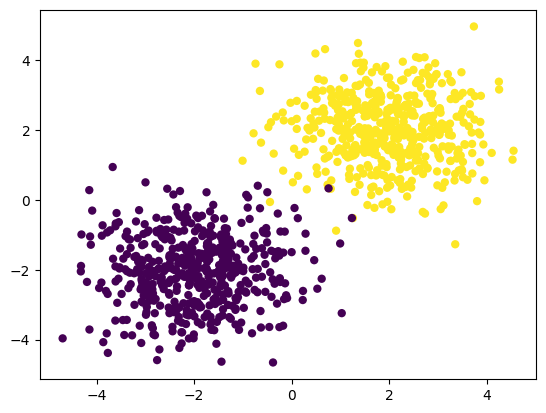

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [ ]:
net = Sequential()
net.add(Linear(2, 2))

net.add(SoftMax())
criterion = ClassNLLCriterionUnstable()

print(net)

Linear 2 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

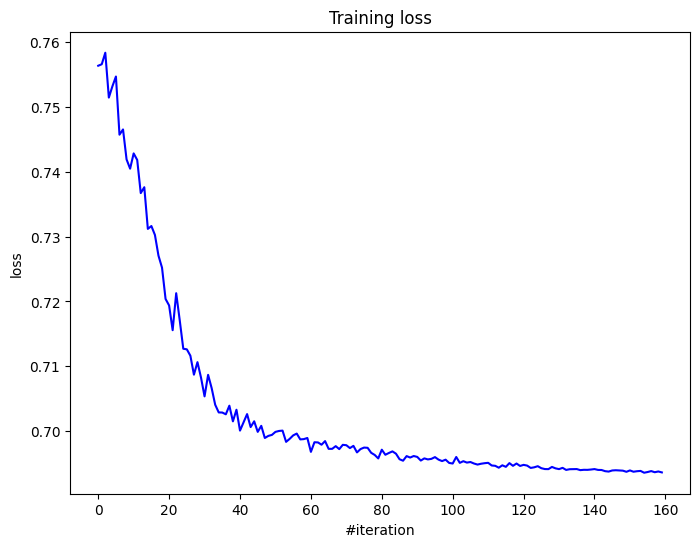

Current loss: 0.693637


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch.astype(np.int32))

        # Backward
        dp = criterion.backward(predictions, y_batch.astype(np.int32))
        net.backward(x_batch, dp)

        # Update weights
        simple_sgd(net.getParameters(),
                   net.getGradParameters(),
                   optimizer_config,
                   optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)